In [1]:
import pandas as pd
import numpy as np
credit = pd.read_csv('data/Credit.csv',index_col=[0])

In [2]:
def adj_r2(r2,n,p):
    return (1 - (1 - r2) * ((n - 1) / (n-p - 1)))

In [3]:
credit.columns.values

array(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender',
       'Student', 'Married', 'Ethnicity', 'Balance'], dtype=object)

## Preprocessing

In [4]:
data = pd.get_dummies(credit, columns = ['Gender', 'Student','Married','Ethnicity'])
data.head(3)

,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_Female,Gender_Male,Student_No,Student_Yes,Married_No,Married_Yes,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian
1,14.891,3606,283,2,34,11,333,0,1,1,0,0,1,0,0,1
2,106.025,6645,483,3,82,15,903,1,0,0,1,0,1,0,1,0
3,104.593,7075,514,4,71,11,580,0,1,1,0,1,0,0,1,0


In [5]:
y= data["Balance"]
X = data.loc[:, data.columns != 'Balance']

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

## Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [27]:
from sklearn.metrics import r2_score
r2= r2_score(y_test, y_pred)
print(f"R2 Score:{r2:.4f} Adj R2 Score:{adj_r2(r2,X_test.shape[0],X_test.shape[1]):.4f}")

R2 Score:0.9571 Adj R2 Score:0.9470


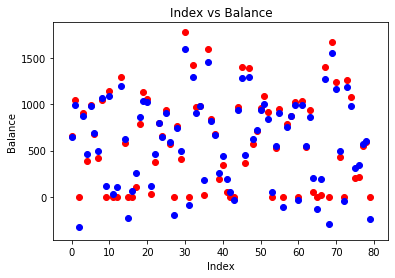

In [40]:
import matplotlib.pyplot as plot
t = range(y_test.shape[0])
plot.scatter(t, y_test, color = 'red')
plot.scatter(t, y_pred, color = 'blue')
plot.title('Index vs Balance')
plot.xlabel('Index')
plot.ylabel('Balance')
plot.show()

## K-Fold Cross Validation

In [41]:
from sklearn.model_selection import cross_val_predict,cross_validate
model = LinearRegression()
score = cross_validate(model,X=X,y=y,cv=5,scoring ='neg_mean_squared_error',return_estimator = True)
y_pred = cross_val_predict(model, X, y, cv=5)
from sklearn.metrics import r2_score
r2 =r2_score(y, y_pred)
print(f"Cross-Validation Error:{abs(score['test_score'].mean()):.4f} R2 Score:{r2:.4f} Adj R2 Score:{adj_r2(r2,X.shape[0],X.shape[1]):.4f}")

Cross-Validation Error:10176.0901 R2 Score:0.9517 Adj R2 Score:0.9499


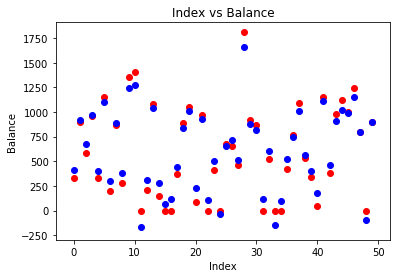

In [46]:
import matplotlib.pyplot as plot
t = range(50)
plot.scatter(t, y[0:50], color = 'red')
plot.scatter(t, y_pred[0:50], color = 'blue')
plot.title('Index vs Balance')
plot.xlabel('Index')
plot.ylabel('Balance')
plot.show()

## Stratified K-Fold Cross Validation

In [19]:
from sklearn.model_selection import cross_val_score,cross_val_predict,StratifiedKFold
sf = StratifiedKFold(n_splits=2)
model = LinearRegression()
score = cross_val_score(model,X=X,y=y,cv=sf,scoring='neg_mean_squared_error')
y_pred = cross_val_predict(model, X, y, cv=sf)
from sklearn.metrics import r2_score
r2 =r2_score(y, y_pred)
print(f"Cross-Validation Error:{abs(score.mean()):.4f} R2 Score:{r2:.4f} Adj R2 Score:{adj_r2(r2,X.shape[0],X.shape[1]):.4f}")

Cross-Validation Error:10377.5884 R2 Score:0.9508 Adj R2 Score:0.9489


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


## Leave One Out Cross Validation

In [48]:
from sklearn.model_selection import cross_val_score,cross_val_predict,LeaveOneOut
loo = LeaveOneOut()
model = LinearRegression()
score = cross_val_score(model,X=X,y=y,cv=loo,scoring='neg_mean_squared_error')
y_pred = cross_val_predict(model, X, y, cv=loo)
from sklearn.metrics import r2_score
r2 =r2_score(y, y_pred)
print(f"Cross-Validation Error:{abs(score.mean()):.4f} R2 Score:{r2:.4f} Adj R2 Score:{adj_r2(r2,X.shape[0],X.shape[1]):.4f}")

Cross-Validation Error:10100.2198 R2 Score:0.9521 Adj R2 Score:0.9502


## Forward Subset Selection

In [46]:
def calculate_score(X,y):
    from sklearn.model_selection import cross_val_score,cross_val_predict
    score = cross_val_score(LinearRegression(),X=X,y=y,cv=5,scoring ='neg_mean_squared_error')
    return abs(score.mean())

In [47]:
import itertools
k= X.shape[1]
remaining_features = list(range(0,k))
features = []
RSS_list = [np.inf]
features_list = dict()
for i in range(1,k+1):
    best_RSS = np.inf
    for combo in itertools.combinations(remaining_features,1):
        score = 0       
        features.append(combo[0])
        score = calculate_score(X[:,features],y)
        features.remove(combo[0])
        
        if  score < best_RSS:
            best_RSS = score
            best_feature = combo[0]
    
    features.append(best_feature)
    remaining_features.remove(best_feature)
            
    features_list[i] = features.copy()
    RSS_list.append(best_RSS)

In [48]:
result = features_list[RSS_list.index(min(RSS_list))]
data.columns[result]

Index(['Rating', 'Income', 'Gender_Male', 'Limit', 'Cards', 'Age',
       'Student_No'],
      dtype='object')

In [49]:
y_pred = cross_val_predict(LinearRegression(), X[:,result], y, cv=5)
from sklearn.metrics import r2_score
r2 =r2_score(y, y_pred)
print(f"Cross-Validation Error:{abs(min(RSS_list)):.4f} R2 Score:{r2:.4f} Adj R2 Score:{adj_r2(r2,X.shape[0],X.shape[1]):.4f}")

Cross-Validation Error:9957.2382 R2 Score:0.9528 Adj R2 Score:0.9509


## Ridge regression

In [50]:
from sklearn import linear_model
scores_list = []
lambdas = [0.05,0.1,0.2,0.5,1]
for l in lambdas:
    reg = linear_model.Ridge(alpha=l)
    score = cross_val_score(reg,X=X,y=y,cv=5,scoring='neg_mean_squared_error')
    scores_list.append(abs(score.mean()))

In [51]:
l = lambdas[scores_list.index(min(scores_list))]
l

0.5

In [52]:
reg = linear_model.Ridge(alpha=l)
y_pred = cross_val_predict(reg, X, y, cv=5)
from sklearn.metrics import r2_score
r2 =r2_score(y, y_pred)
print(f"Cross-Validation Error:{abs(score.mean()):.4f} R2 Score:{r2:.4f} Adj R2 Score:{adj_r2(r2,X.shape[0],X.shape[1]):.4f}")

Cross-Validation Error:10140.2521 R2 Score:0.9519 Adj R2 Score:0.9501


## Lasso regression

In [53]:
from sklearn import linear_model
scores_list = []
lambdas = [0.05,0.1,0.2,0.5,1]
for l in lambdas:
    reg = linear_model.Lasso(alpha=l)
    score = cross_val_score(reg,X=X,y=y,cv=5,scoring='neg_mean_squared_error')
    scores_list.append(abs(score.mean()))

In [54]:
l = lambdas[scores_list.index(min(scores_list))]
l

1

In [55]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=l)
score = cross_val_score(reg,X=X,y=y,cv=5,scoring='neg_mean_squared_error')
y_pred = cross_val_predict(reg, X, y, cv=5)
from sklearn.metrics import r2_score
r2 =r2_score(y, y_pred)
print(f"Cross-Validation Error:{abs(score.mean()):.4f} R2 Score:{r2:.4f} Adj R2 Score:{adj_r2(r2,X.shape[0],X.shape[1]):.4f}")

Cross-Validation Error:10128.5030 R2 Score:0.9520 Adj R2 Score:0.9501


## PCA

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([0.17673128, 0.14692159, 0.13973825, 0.12399704, 0.11179468])

In [57]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(pca.transform(X_train),y_train)
y_pred = model.predict(pca.transform(X_test))

In [58]:
from sklearn.metrics import r2_score
rs= r2_score(y_test, y_pred)
print(f"R2 Score:{r2:.4f} Adj R2 Score:{adj_r2(r2,pca.transform(X_test).shape[0],pca.transform(X_test).shape[1]):.4f}")

R2 Score:0.9520 Adj R2 Score:0.9487
